Copyright (c) Microsoft Corporation. All rights reserved. 

Licensed under the MIT License.

# Tune LightGBM with FLAML Library


## 1. Introduction

FLAML is a Python library (https://github.com/microsoft/FLAML) designed to automatically produce accurate machine learning models 
with low computational cost. It is fast and economical. The simple and lightweight design makes it easy 
to use and extend, such as adding new learners. FLAML can 
- serve as an economical AutoML engine,
- be used as a fast hyperparameter tuning tool, or 
- be embedded in self-tuning software that requires low latency & resource in repetitive
   tuning tasks.

In this notebook, we demonstrate how to use FLAML library to tune hyperparameters of LightGBM with a regression example.

FLAML requires `Python>=3.7`. To run this notebook example, please install flaml with the `notebook` option:
```bash
pip install flaml[notebook]
```

In [1]:
%pip install flaml[notebook]==1.0.10

## 2. Regression Example
### Load data and preprocess

Download [houses dataset](https://www.openml.org/d/537) from OpenML. The task is to predict median price of the house in the region based on demographic composition and a state of housing market in the region.

In [1]:
from flaml.data import load_openml_dataset
X_train, X_test, y_train, y_test = load_openml_dataset(dataset_id=537, data_dir='./')

/root/.local/lib/python3.9/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


download dataset from openml
Dataset name: houses
X_train.shape: (15480, 8), y_train.shape: (15480,);
X_test.shape: (5160, 8), y_test.shape: (5160,)


### Run FLAML
In the FLAML automl run configuration, users can specify the task type, time budget, error metric, learner list, whether to subsample, resampling strategy type, and so on. All these arguments have default values which will be used if users do not provide them. 

In [2]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

In [3]:
settings = {
    "time_budget": 240,  # total running time in seconds
    "metric": 'r2',  # primary metrics for regression can be chosen from: ['mae','mse','r2','rmse','mape']
    "estimator_list": ['lgbm'],  # list of ML learners; we tune lightgbm in this example
    "task": 'regression',  # task type    
    "log_file_name": 'houses_experiment.log',  # flaml log file
    "seed": 7654321,    # random seed
}

In [4]:
'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, **settings)

[flaml.automl: 07-01 15:22:15] {2427} INFO - task = regression
[flaml.automl: 07-01 15:22:15] {2429} INFO - Data split method: uniform
[flaml.automl: 07-01 15:22:15] {2432} INFO - Evaluation method: cv
[flaml.automl: 07-01 15:22:15] {2501} INFO - Minimizing error metric: 1-r2
[flaml.automl: 07-01 15:22:15] {2641} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl: 07-01 15:22:15] {2933} INFO - iteration 0, current learner lgbm
[flaml.automl: 07-01 15:22:16] {3061} INFO - Estimated sufficient time budget=1981s. Estimated necessary time budget=2s.
[flaml.automl: 07-01 15:22:16] {3108} INFO -  at 0.3s,	estimator lgbm's best error=0.7383,	best estimator lgbm's best error=0.7383
[flaml.automl: 07-01 15:22:16] {2933} INFO - iteration 1, current learner lgbm
[flaml.automl: 07-01 15:22:16] {3108} INFO -  at 0.5s,	estimator lgbm's best error=0.7383,	best estimator lgbm's best error=0.7383
[flaml.automl: 07-01 15:22:16] {2933} INFO - iteration 2, current learner lgbm
[flaml.automl:

### Best model and metric

In [5]:
''' retrieve best config'''
print('Best hyperparmeter config:', automl.best_config)
print('Best r2 on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best hyperparmeter config: {'n_estimators': 436, 'num_leaves': 46, 'min_child_samples': 15, 'learning_rate': 0.0825101833775657, 'log_max_bin': 10, 'colsample_bytree': 0.6884091116362046, 'reg_alpha': 0.0010949400705571237, 'reg_lambda': 0.004934208563558304}
Best r2 on validation data: 0.8442
Training duration of best run: 1.668 s


In [6]:
automl.model.estimator

LGBMRegressor(colsample_bytree=0.6884091116362046,
              learning_rate=0.0825101833775657, max_bin=1023,
              min_child_samples=15, n_estimators=436, num_leaves=46,
              reg_alpha=0.0010949400705571237, reg_lambda=0.004934208563558304,
              verbose=-1)

<BarContainer object of 8 artists>

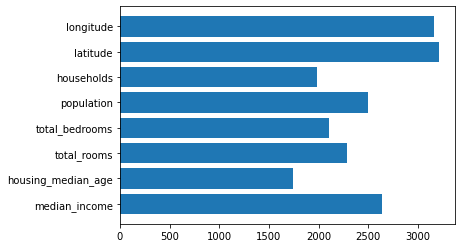

In [7]:
import matplotlib.pyplot as plt
plt.barh(automl.feature_names_in_, automl.feature_importances_)

In [8]:
''' pickle and save the automl object '''
import pickle
with open('automl.pkl', 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)

In [9]:
''' compute predictions of testing dataset ''' 
y_pred = automl.predict(X_test)
print('Predicted labels', y_pred)
print('True labels', y_test)

Predicted labels [162131.66541776 261207.15681479 157976.50985102 ... 205999.47588989
 223985.57564169 277733.77442341]
True labels 14740    136900.0
10101    241300.0
20566    200700.0
2670      72500.0
15709    460000.0
           ...   
13132    121200.0
8228     137500.0
3948     160900.0
8522     227300.0
16798    265600.0
Name: median_house_value, Length: 5160, dtype: float64


In [10]:
''' compute different metric values on testing dataset'''
from flaml.ml import sklearn_metric_loss_score
print('r2', '=', 1 - sklearn_metric_loss_score('r2', y_pred, y_test))
print('mse', '=', sklearn_metric_loss_score('mse', y_pred, y_test))
print('mae', '=', sklearn_metric_loss_score('mae', y_pred, y_test))

r2 = 0.8522136092023422
mse = 1953515373.4904487
mae = 29086.15911420206


In [11]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=settings['log_file_name'], time_budget=60)

for config in config_history:
    print(config)

{'Current Learner': 'lgbm', 'Current Sample': 15480, 'Current Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.09999999999999995, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.09999999999999995, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0}}
{'Current Learner': 'lgbm', 'Current Sample': 15480, 'Current Hyper-parameters': {'n_estimators': 22, 'num_leaves': 4, 'min_child_samples': 18, 'learning_rate': 0.2293009676418639, 'log_max_bin': 9, 'colsample_bytree': 0.9086551727646448, 'reg_alpha': 0.0015561782752413472, 'reg_lambda': 0.33127416269768944}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 22, 'num_leaves': 4, 'min_child_samples': 18, 'learning_rate': 0.2293009676418639, 'log_max_bin': 9, 'colsample_b

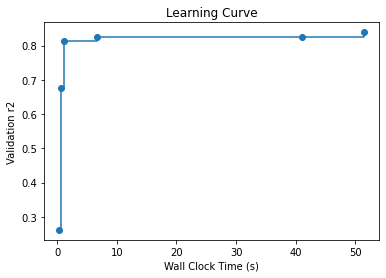

In [12]:
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation r2')
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

## 3. Comparison with alternatives

### FLAML's accuracy

In [13]:
print('flaml (4min) r2', '=', 1 - sklearn_metric_loss_score('r2', y_pred, y_test))

flaml (4min) r2 = 0.8522136092023422


### Default LightGBM

In [14]:
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor()

In [15]:
lgbm.fit(X_train, y_train)

LGBMRegressor()

In [16]:
y_pred = lgbm.predict(X_test)
from flaml.ml import sklearn_metric_loss_score
print('default lgbm r2', '=', 1 - sklearn_metric_loss_score('r2', y_pred, y_test))

default lgbm r2 = 0.8296179648694404


### Optuna LightGBM Tuner

In [17]:
# uncomment the following line if optuna is not installed
# %pip install optuna==2.8.0

In [18]:
from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(X_train, y_train, test_size=0.1)
import optuna.integration.lightgbm as lgb
dtrain = lgb.Dataset(train_x, label=train_y)
dval = lgb.Dataset(val_x, label=val_y)
params = {
    "objective": "regression",
    "metric": "regression",
    "verbosity": -1,
}

In [19]:
%%time
model = lgb.train(params, dtrain, valid_sets=[dtrain, dval], verbose_eval=10000)        


[I 2022-07-01 15:26:25,531] A new study created in memory with name: no-name-0bd516fd-ed41-4e00-874e-ff99ff30eb94
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
bagging, val_score: 2199305116.477652: 100%|##########| 10/10 [01:22<00:00,  8.25s/it]
feature_fraction_stage2, val_score: 2199305116.477652:  17%|#6        | 1/6 [00:06<00:31,  6.22s/it][I 2022-07-01 15:29:52,235] Trial 37 finished with value: 2199305116.4776516 and parameters: {'feature_fraction': 0.9159999999999999}. Best is trial 37 with value: 2199305116.4776516.
feature_fraction_stage2, val_score: 2199305116.477652:  33%|###3      | 2/6 [00:12<00:25,  6.39s/it][

CPU times: user 6min 30s, sys: 17 s, total: 6min 47s
Wall time: 6min 50s


In [20]:
y_pred = model.predict(X_test)
from flaml.ml import sklearn_metric_loss_score
print('Optuna LightGBM Tuner r2', '=', 1 - sklearn_metric_loss_score('r2', y_pred, y_test))

Optuna LightGBM Tuner r2 = 0.8429583826070053


## 4. Add a customized LightGBM learner in FLAML
The native API of LightGBM allows one to specify a custom objective function in the model constructor. You can easily enable it by adding a customized LightGBM learner in FLAML. In the following example, we show how to add such a customized LightGBM learner with a custom objective function.

### Create a customized LightGBM learner with a custom objective function

In [21]:
import numpy as np 

''' define your customized objective function '''
def my_loss_obj(y_true, y_pred):
    c = 0.5
    residual = y_pred - y_true
    grad = c * residual /(np.abs(residual) + c)
    hess = c ** 2 / (np.abs(residual) + c) ** 2
    # rmse grad and hess
    grad_rmse = residual
    hess_rmse = 1.0
    
    # mae grad and hess
    grad_mae = np.array(residual)
    grad_mae[grad_mae > 0] = 1.
    grad_mae[grad_mae <= 0] = -1.
    hess_mae = 1.0

    coef = [0.4, 0.3, 0.3]
    return coef[0] * grad + coef[1] * grad_rmse + coef[2] * grad_mae, \
        coef[0] * hess + coef[1] * hess_rmse + coef[2] * hess_mae


from flaml.model import LGBMEstimator

''' create a customized LightGBM learner class with your objective function '''
class MyLGBM(LGBMEstimator):
    '''LGBMEstimator with my_loss_obj as the objective function
    '''

    def __init__(self, **config):
        super().__init__(objective=my_loss_obj, **config)

### Add the customized learner in FLAML

In [22]:
automl = AutoML()
automl.add_learner(learner_name='my_lgbm', learner_class=MyLGBM)
settings = {
    "time_budget": 150,  # total running time in seconds
    "metric": 'r2',  # primary metrics for regression can be chosen from: ['mae','mse','r2']
    "estimator_list": ['my_lgbm',],  # list of ML learners; we tune lightgbm in this example
    "task": 'regression',  # task type    
    "log_file_name": 'houses_experiment_my_lgbm.log',  # flaml log file
}
automl.fit(X_train=X_train, y_train=y_train, **settings)

[flaml.automl: 07-01 15:33:17] {2427} INFO - task = regression
[flaml.automl: 07-01 15:33:17] {2429} INFO - Data split method: uniform
[flaml.automl: 07-01 15:33:17] {2432} INFO - Evaluation method: cv
[flaml.automl: 07-01 15:33:17] {2501} INFO - Minimizing error metric: 1-r2
[flaml.automl: 07-01 15:33:17] {2641} INFO - List of ML learners in AutoML Run: ['my_lgbm']
[flaml.automl: 07-01 15:33:17] {2933} INFO - iteration 0, current learner my_lgbm
[flaml.automl: 07-01 15:33:17] {3061} INFO - Estimated sufficient time budget=1586s. Estimated necessary time budget=2s.
[flaml.automl: 07-01 15:33:17] {3108} INFO -  at 0.2s,	estimator my_lgbm's best error=2.9883,	best estimator my_lgbm's best error=2.9883
[flaml.automl: 07-01 15:33:17] {2933} INFO - iteration 1, current learner my_lgbm
[flaml.automl: 07-01 15:33:18] {3108} INFO -  at 0.4s,	estimator my_lgbm's best error=2.9883,	best estimator my_lgbm's best error=2.9883
[flaml.automl: 07-01 15:33:18] {2933} INFO - iteration 2, current learne

In [23]:
print('Best hyperparmeter config:', automl.best_config)
print('Best r2 on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

y_pred = automl.predict(X_test)
print('Predicted labels', y_pred)
print('True labels', y_test)

from flaml.ml import sklearn_metric_loss_score
print('r2', '=', 1 - sklearn_metric_loss_score('r2', y_pred, y_test))
print('mse', '=', sklearn_metric_loss_score('mse', y_pred, y_test))
print('mae', '=', sklearn_metric_loss_score('mae', y_pred, y_test))

Best hyperparmeter config: {'n_estimators': 95, 'num_leaves': 221, 'min_child_samples': 10, 'learning_rate': 0.4130805075333333, 'log_max_bin': 10, 'colsample_bytree': 0.8422311526890249, 'reg_alpha': 0.007704104902643932, 'reg_lambda': 0.0031517673595496476}
Best r2 on validation data: 0.8368
Training duration of best run: 1.508 s
Predicted labels [161485.59767093 248585.87889042 157837.93378106 ... 184356.07034452
 223247.80995858 259281.61167122]
True labels 14740    136900.0
10101    241300.0
20566    200700.0
2670      72500.0
15709    460000.0
           ...   
13132    121200.0
8228     137500.0
3948     160900.0
8522     227300.0
16798    265600.0
Name: median_house_value, Length: 5160, dtype: float64
r2 = 0.842983315140684
mse = 2075526075.9236298
mae = 30102.91056064235
